# Multi-Variate Air Pollution Forecasting 

# Objective: 
- Predicting air pollution according to 8 variable: 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain'

# About the Data:
- The datset used here is the airpolution dataset of Beijing city of China. 
- Data is collected from the following website: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
- The feature list in the raw data is explained as follow:

    * No: number of rows
    * year: year of data in every row
    * month: month of data in every row
    * day: day of data in every row
    * hour: hour of data in every row
    * pm2.5: PM2.5 refers to particulate matter with a diameter of 2.5 micrometers or smaller. These fine particles are a significant component of air pollution and can have serious health effects due to their ability to penetrate deep into the lungs and enter the bloodstream.
    * DEWP: The dew point is the temperature at which air becomes saturated with moisture and water vapor begins to condense into liquid water. It is a critical parameter in understanding and predicting weather
    * TEMP: Temperature
    * PRES: Pressure
    * cbwd: Combined wind direction
    * Iws: Cumulated wind speed
    * Is: Cumulated hours of snow
    * Ir: Cumulated hours of rain



# General Forecasting Process of LSTM Models:
* Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences. 
* After preparing data, data is split into train and test 
* Train data is used for training the model
* Test data is used for forecasting
* In this notebook, 8 features (or variables) are being used to forecast the air pollution over time. 

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU

# Data preperation and preprocessing

In [2]:
df = pd.read_csv('Book1.csv')
df.head()

,"No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir"
0,"1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0"
1,"2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0"
2,"3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0"
3,"4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0"
4,"5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0"


In [3]:
# We replaced the names with string and separate them and determine the new columns to our df
df[['No','Year', 'Month', 'Day', 'Hour', 'pollution', 'dew point', 'temperature', 'pressure', 'wind direction', 'wind speed', 'snow', 'rain']] = df['No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir'].str.split(',', expand=True)

# Drop previous columns and column "No"
df.drop(columns=['No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir'], inplace=True)
df.drop(columns=['No'], inplace=True)

# We have a copy of our df in data"
data_main = df.copy()

In [4]:
# Let's convert the date-time information into a single date-time so that we can use it as an index in Pandas
def combine_datetime(df):
    year = str(df['Year'])
    month = str(df['Month'])
    day = str(df['Day'])
    hour = str(df['Hour'])
    combined_string = year + '-' + month + '-' + day + ' ' + hour
    return datetime.strptime(combined_string, '%Y-%m-%d %H')


df['Date'] = df.apply(combine_datetime, axis=1)
df.drop(columns=['Year', 'Month', 'Day', 'Hour'], axis=1)
df = df[['Date', 'pollution', 'dew point', 'temperature', 'pressure', 'wind direction', 'wind speed', 'snow', 'rain']]

# Set 'Date' column as indx for df
df.set_index('Date', inplace = True) 

# Let's see the NA values for "pollution" column
df[df['pollution'] == 'NA']

# Replace "NA" values with 0
df.iloc[:, 0].replace('NA', 0)

# first 24 hours of df is dropped
df = df[24 :]

# Save the df in file named:pollution.csv
df.to_csv('pollution.csv')

# Read 'pollution.csv'
df = pd.read_csv('pollution.csv')

# Set 'Date' as index for df
df = df.set_index('Date')

df.head()

,pollution,dew point,temperature,pressure,wind direction,wind speed,snow,rain
Date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# Plotting the Data

<Figure size 2000x2000 with 0 Axes>

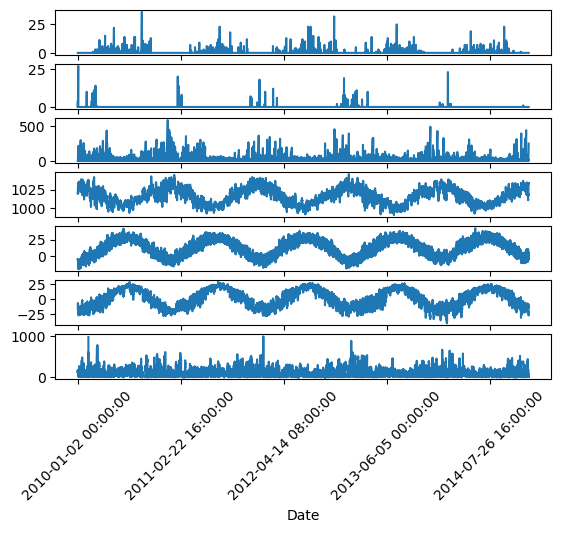

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=1,  sharex='col')
fig = plt.figure(figsize=(20, 20))
#add DataFrames to subplots
df['rain'].plot(ax=axes[0])
df['snow'].plot(ax=axes[1])
df['wind speed'].plot(ax=axes[2])
df['pressure'].plot(ax=axes[3])
df['temperature'].plot(ax=axes[4])
df['dew point'].plot(ax=axes[5])
df['pollution'].plot(ax=axes[6])
plt.sca(axes[6])
plt.xticks(rotation = 45)
plt.show()

# Long Short Term Model (LSTM)¶

- Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are well-suited to time series forecasting due to their ability to learn long-term dependencies. LSTMs are particularly effective for datasets where the temporal order and lag relationships are critical, such as in weather forecasting, stock prices, and many other sequential data problems.
- Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) model developed due to the vanishing gradient problem in traditional RNNs. LSTM method is used to capture long term dependencies and non-linear patterns in the data. LSTM models are trained according to backpropagation through time which reduces the vanishing gradient problem to optimize the network parameters.
- LSTM networks contain memory cells that allow them to retain information over time. Each LSTM cell has 3 gates as forget gate, input gate and output gate. Through forget gate, it will forget unimportant information since it determines which information is considered as important information. In the input gate new information will be added to the LSTM cell. The output gate also provides us with the final prediction of model. LSTM can be successfully directed for multivariate time series forecasting. Due to its liability to retain the information over long sequence of data, it is of most importance for larger and more complex data.

# Data Preparation for LSTM model
- Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems and input values must be normalized.  
- We want to predict the pollution for the current time.
- wind direction column is categorical and should be encoded to numeric values.
- Data is loaded and is normalized using MinMaxScaler
- All values are made sure to be 'float' type
- "lstm_data_preparation" function is used to frame the final data
- Unneeded columns that we are not going to forecast them are dropped from a final dataframe. 
- We are going to have 8 variables or features () and forecst the air pollution "pollution" as an output.
- lag of time of 1 is investigated first and we are going to look back for only 1 time to do the forecasting first. 
- An algorithm is developed to learn how to predict the output patterns from the input patterns.

In [6]:
#Load the dataset
df.to_csv('pollution.csv')
df = pd.read_csv('pollution.csv', header=0, index_col=0)

# Column "wind direction" is encoded to hold integer values
encoder = LabelEncoder()
values = df.values
values[:,4] = encoder.fit_transform(values[:,4])

# Let's assure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# This is being used as number of features
scaled.shape[1] 

8

In [7]:
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [8]:
# convert series to supervised learning
def lstm_data_preparation(data, time_lag=3, number_output=1, dropnan=True):
    
    if type(data) is list:
        number_variables = 1
    else:
        number_variables = data.shape[1]
    
    df = pd.DataFrame(data)
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(time_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(number_variables)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, number_output):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(number_variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(number_variables)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
         agg.dropna(inplace=True)
    return agg

In [9]:
# frame as supervised learning
reframed = lstm_data_preparation(scaled, time_lag=3, number_output=1)
reframed.head(2)

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.0,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.0,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


In [10]:
len(reframed.columns)

32

- We have 3*8=24 input features/variables for the 3 hours time lag
- We are interested in forecasting only "pollution" which is the first column using 24 features. Thus, the rest of the columns will be dropped from our reframed dataframe  [25,26,27,28,29,30,31,32]. 

- Let's have a look into a prepared data for LSTM forecasting

In [11]:
reframed.head(2)

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.0,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.0,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


# Multivariate LSTM Forecasting
- In this section, we will define the LSTM modela to fit the multivariate input data.
- First, we will split data into train/test sets. 
- We will train the data by fitting it to the four years of data. Then, we will evaluate it on the remaining 4 years.

## Train/Test Dataset Preparation

- Let's define a function to convert reframed dataset into train and test sets (4 years for training and last year for forecasting)

In [12]:
def train_test_data(data):
    values = data.values
    n_train_hours = 365*24*4
    
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    x_train, y_train = train[:, :24], train[:, -8]
    x_test, y_test = test[:, :24], test[:, -8]
    
    return x_train, y_train, x_test, y_test

In [13]:
x_train1, y_train1, x_test1, y_test1 = train_test_data(reframed)
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape

((35040, 24), (35040,), (6117, 24), (6117,))

## Reshape Train/Test Dataset (into 3D shape)

- Input data needs to be 3D for time series forecasting  (number of rows, time_lag, number_variables) 
- Advanced models such as deep learning methods (e.g., LSTMs, GRU, CNNs) require 3D data structures to capture intricate patterns.

In [14]:
time_lag = 3
n_features = 8
x_train1 = x_train1.reshape((x_train1.shape[0], time_lag, n_features))
x_train1.shape

(35040, 3, 8)

In [15]:
time_lag = 3
n_features = 8
x_test1 = x_test1.reshape((x_test1.shape[0], time_lag, n_features))
x_test1.shape

(6117, 3, 8)

In [16]:
print(x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape)

(35040, 3, 8) (35040,) (6117, 3, 8) (6117,)


In [17]:
# define LSTM model and fit the data
def LSTM_Model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train1.shape[1], x_train1.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=15, batch_size=72, verbose=2, shuffle=False)
    return model

In [18]:
lstm_model = LSTM_Model(x_train1, y_train1)



Epoch 1/15

487/487 - 3s - loss: 0.0296 - 3s/epoch - 5ms/step
Epoch 2/15
487/487 - 1s - loss: 0.0188 - 755ms/epoch - 2ms/step
Epoch 3/15
487/487 - 1s - loss: 0.0169 - 748ms/epoch - 2ms/step
Epoch 4/15
487/487 - 1s - loss: 0.0150 - 749ms/epoch - 2ms/step
Epoch 5/15
487/487 - 1s - loss: 0.0139 - 755ms/epoch - 2ms/step
Epoch 6/15
487/487 - 1s - loss: 0.0135 - 764ms/epoch - 2ms/step
Epoch 7/15
487/487 - 1s - loss: 0.0133 - 755ms/epoch - 2ms/step
Epoch 8/15
487/487 - 1s - loss: 0.0133 - 822ms/epoch - 2ms/step
Epoch 9/15
487/487 - 1s - loss: 0.0132 - 883ms/epoch - 2ms/step
Epoch 10/15
487/487 - 1s - loss: 0.0132 - 868ms/epoch - 2ms/step
Epoch 11/15
487/487 - 1s - loss: 0.0132 - 799ms/epoch - 2ms/step
Epoch 12/15
487/487 - 1s - loss: 0.0131 - 808ms/epoch - 2ms/step
Epoch 13/15
487/487 - 1s - loss: 0.0131 - 765ms/epoch - 2ms/step
Epoch 14/15
487/487 - 1s - loss: 0.0132 - 760ms/epoch - 2ms/step
Epoch 15/15
487/487 - 1s - loss: 0.0131 - 758ms/epoch - 2ms/step


In [19]:
x_test1.shape

(6117, 3, 8)

In [20]:
# Predict the tst data
predictions = lstm_model.predict(x_test1)

192/192 [==============================] - 1s 880us/step


## Model Evaluation

## Some Preferred Metrics for LSTM in Time Series Forecasting:
1. Mean Squared Error (MSE):
    * Measures the average squared difference between the predicted and actual values.
    * Suitable for capturing the overall prediction error magnitude.
2. Root Mean Squared Error (RMSE):
    * The square root of MSE, providing error in the same units as the original data.
    * Easier to interpret than MSE.
3. Mean Absolute Error (MAE):
    * Measures the average absolute difference between the predicted and actual values.
    * Less sensitive to outliers compared to MSE.
4. Mean Absolute Percentage Error (MAPE):
    * Measures the average absolute percentage difference between the predicted and actual values.
    * Useful for understanding the prediction accuracy in percentage terms.

- both test data and predictions are inverse transformed to the real expected values and the model is evaluated. 

In [21]:
time_lag = 3
n_features = 8

# Reshape x_test1 and y_test1 data
x_test1 = x_test1.reshape((x_test1.shape[0], time_lag*n_features))
y_test1 = y_test1.reshape((len(y_test1), 1))

# Concatenate the y-test1 and predictions with the x_test1[:, -7:]
concat_predictions = np.concatenate((predictions, x_test1[:, -7:]), axis=1)
concat_y_test = np.concatenate((y_test1, x_test1[:, -7:]), axis=1)

In [22]:
# Inverse transform the Min-Max scaled data
invesed_predictions = scaler.inverse_transform(concat_predictions)
inversed_y_test = scaler.inverse_transform(concat_y_test)

In [23]:
predictions

array([[0.24802925],
       [0.24573015],
       [0.28143924],
       ...,
       [0.00664341],
       [0.0062149 ],
       [0.00403087]], dtype=float32)

[]

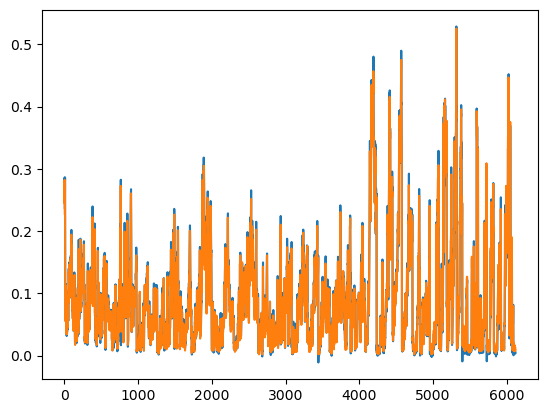

In [24]:
plt.plot(predictions)
plt.plot(y_test1)

plt.plot()

In [25]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(inversed_y_test, invesed_predictions, squared=False)

In [26]:
round(mse, 2)

2.28